In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# This is a small project for fun

This Jupyter notebook replicate a post by Yoav Git, a Quant researcher for Gresham Investment Management.

The blog talks about the Trend following strategy. The following code generates signal from MACD and prediction of MACD for better signal for risk management.

In [450]:
df = yf.download('SOL-USD', start = '2020-01-01')
df = df['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [451]:
n = len(df)
n

1475

In [452]:
n_train = int(n)
train = df[:n_train]
test = df[n_train:]

<Axes: xlabel='Date'>

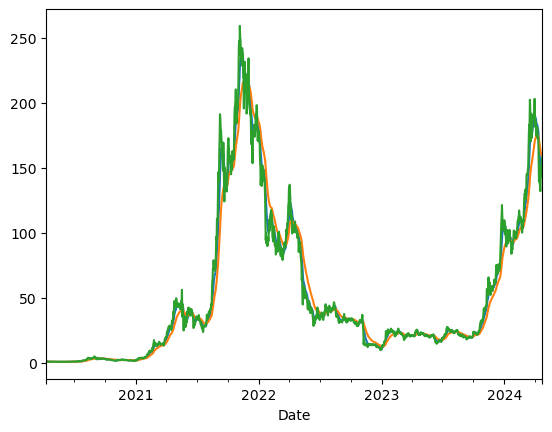

In [453]:
fast_train = train.ewm(span = 10).mean()
median_train = train.ewm(span = 30).mean()
macd = fast_train - median_train
fast_train.plot()
median_train.plot()
train.plot()

In [454]:
def Standard_scaler(x, pred_vec):
    """
    x: pd.Series
    pred_vec: np.array or pd.Series
    Standardizes the last value of the time series 'x' and the prediction vector 'pred_vec'.
    """
    n = len(x)
    mu = np.mean(x[:n])
    sd = np.std(x[:n])
    normal_x = (x.iloc[-1] - mu) / sd
    normal_pred = (pred_vec.copy() - mu) / sd 
    return normal_x, normal_pred

In [455]:
macd

Date
2020-04-10     0.000000
2020-04-11    -0.005808
2020-04-12    -0.002481
2020-04-13    -0.006562
2020-04-14    -0.015499
                ...    
2024-04-19   -12.416761
2024-04-20   -11.284923
2024-04-21   -10.582344
2024-04-22    -8.932553
2024-04-23    -7.426243
Name: Adj Close, Length: 1475, dtype: float64

In [456]:
def future_ewma_and_macd(slow_ewma_t, fast_ewma_t, w, v, p_t, n):
    # Calculate future values for the slow EWMA
    future_slow_ewma = (w**n) * slow_ewma_t + (1 - w**n) * p_t

    # Calculate future values for the fast EWMA
    future_fast_ewma = (v**n) * fast_ewma_t + (1 - v**n) * p_t

    # Calculate the MACD for future values
    future_macd = future_fast_ewma - future_slow_ewma

    return future_slow_ewma, future_fast_ewma, future_macd

In [457]:
slow_span = 30
fast_span = 10
w = 1 - 2 / (1 + slow_span)
v = 1 - 2 / (1 + fast_span)
days = len(train)
n = 10

pred = np.zeros((days, n+1))
for i in range(days):
    pred[i, 0] = fast_train.iloc[i] - median_train.iloc[i]
    for j in range(n):
        _, _, pred[i, j+1] = future_ewma_and_macd(median_train.iloc[i], fast_train.iloc[i], w, v, train.iloc[i], j)

In [458]:
Standard_scaler(macd[:4], pred[3])
print(pred[20])
print((macd.iloc[20] - macd.iloc[:20].mean())/macd.iloc[:20].std())
print(macd.iloc[:20].mean())
print(macd.iloc[:20].std())

[-0.0054899  -0.0054899  -0.00181109  0.00102591  0.00318529  0.00480072
  0.00598084  0.00681395  0.00737168  0.00771209  0.00788217]
1.4200019215441997
-0.020919706571498754
0.010866044545069226


In [459]:
# Normalize Data
macd_scaled = np.zeros_like(macd)
pred_scaled = np.zeros_like(pred)

print(macd.shape, pred.shape)
for i in range(len(macd)-1):
    macd_scaled[i], pred_scaled[i] = Standard_scaler(macd[:i+2], pred[i+1])

(1475,) (1475, 11)


### We omit the first 100 data, because the scaler is not accurate

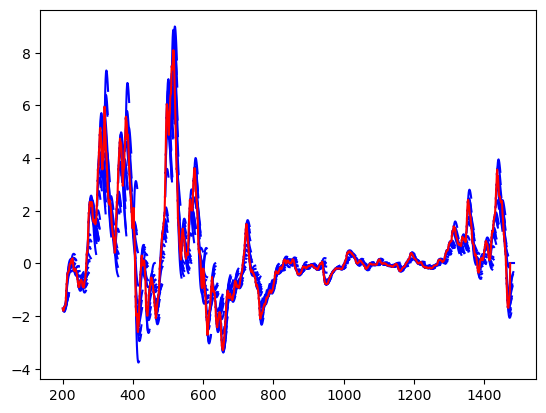

In [464]:
for i in range(200, days):
    plt.plot(range(i, i+n+1), pred_scaled[i], 'b')
plt.plot(range(200, days), macd_scaled[200:], 'r')